In [148]:
import torch
import polars as pl 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using CUDA


In [149]:
data_df = pl.read_csv("data/google_stock_price_train_yfinance.csv")

data_df

Close,High,Low,Open,Volume,Date,Open_s,High_s,Low_s,Close_s,Volume_s
f64,f64,f64,f64,i64,str,f64,f64,f64,f64,f64
2.499133,2.591785,2.390042,2.490664,897427216,"""2004-08-19""",-1.60523,-1.602328,-1.608212,-1.604091,4.281968
2.697639,2.716817,2.503118,2.51582,458857488,"""2004-08-20""",-1.602471,-1.588694,-1.595726,-1.582314,1.698872
2.724787,2.826406,2.71607,2.758411,366857939,"""2004-08-23""",-1.575869,-1.576745,-1.572211,-1.579336,1.157011
2.61196,2.779581,2.579581,2.770615,306396159,"""2004-08-24""",-1.574531,-1.58185,-1.587282,-1.591713,0.800902
2.640104,2.689918,2.587302,2.614201,184645512,"""2004-08-25""",-1.591683,-1.591627,-1.58643,-1.588626,0.083813
…,…,…,…,…,…,…,…,…,…,…
39.953499,40.348999,39.816002,40.317001,32954000,"""2016-10-26""",2.542764,2.514772,2.524529,2.504705,-0.809622
39.767502,40.1745,39.575001,40.049999,54984000,"""2016-10-27""",2.513484,2.495744,2.497916,2.484301,-0.67987
39.768501,40.774502,39.679501,40.4175,85398000,"""2016-10-28""",2.553784,2.561169,2.509456,2.484411,-0.500737


In [150]:
import numpy as np

# RSI
window_rsi = 14
delta = data_df["Close_s"].diff().alias("rsi")

gain = delta.clip(lower_bound=0)
loss = -delta.clip(upper_bound=0)

avg_gain = gain.rolling_mean(window_size=window_rsi, min_periods=1)
avg_loss = loss.rolling_mean(window_size=window_rsi, min_periods=1)

rs = avg_gain / avg_loss

# MACD
short_span = 12
long_span = 26
signal_span = 9

macd = data_df["Close_s"].ewm_mean(span=short_span, adjust=False) - data_df[ "Close_s" ].ewm_mean(span=long_span, adjust=False)
signal = macd.ewm_mean(span=signal_span, adjust=False)

# Bollinger Bands
window_bollinger = 20
mid = data_df['Close_s'].rolling_mean(window_size=window_bollinger)
upper = mid + 2 * data_df['Close_s'].rolling_std(window_size=window_bollinger)
lower = mid - 2 * data_df['Close_s'].rolling_std(window_size=window_bollinger)

# 3 day price difference
# returns = data_df['Close_s'].shift(-3).alias("3_day_price_diff") - data_df['Close_s']
# print(returns)

# 3 day percent change
three_day_future = data_df['Close'].shift(-3).alias("3_day_future")
returns = (data_df['Close'].shift(-3).alias("3_day_price_diff") - data_df['Close']) / data_df['Close']
print(returns.min(), returns.max(), returns.mean(), returns.median())

# print rows where max is 
print(data_df.filter(returns > 25))


data_df = data_df.with_columns(
    # pl.col("Close_s").rolling_mean(20).alias("sma_20"),
    # rs / (1 + rs).alias("rsi") / 100,
    # macd.alias("MACD"),
    # signal.alias("Signal"),
    # upper.alias("Upper"),
    # lower.alias("Lower"),
    # pl.col('Date').str.to_datetime().dt.weekday().alias("Day") / 7,
    # pl.col('Date').str.to_datetime().dt.month().alias("Month") / 12,
    returns,
    three_day_future
)

data_df

-0.14482663815788502 0.3339028177965871 0.003234915979787474 0.0032746017798223623
shape: (0, 11)
┌───────┬──────┬─────┬──────┬───┬────────┬───────┬─────────┬──────────┐
│ Close ┆ High ┆ Low ┆ Open ┆ … ┆ High_s ┆ Low_s ┆ Close_s ┆ Volume_s │
│ ---   ┆ ---  ┆ --- ┆ ---  ┆   ┆ ---    ┆ ---   ┆ ---     ┆ ---      │
│ f64   ┆ f64  ┆ f64 ┆ f64  ┆   ┆ f64    ┆ f64   ┆ f64     ┆ f64      │
╞═══════╪══════╪═════╪══════╪═══╪════════╪═══════╪═════════╪══════════╡
└───────┴──────┴─────┴──────┴───┴────────┴───────┴─────────┴──────────┘


Close,High,Low,Open,Volume,Date,Open_s,High_s,Low_s,Close_s,Volume_s,3_day_price_diff,3_day_future
f64,f64,f64,f64,i64,str,f64,f64,f64,f64,f64,f64,f64
2.499133,2.591785,2.390042,2.490664,897427216,"""2004-08-19""",-1.60523,-1.602328,-1.608212,-1.604091,4.281968,0.045146,2.61196
2.697639,2.716817,2.503118,2.51582,458857488,"""2004-08-20""",-1.602471,-1.588694,-1.595726,-1.582314,1.698872,-0.021328,2.640104
2.724787,2.826406,2.71607,2.758411,366857939,"""2004-08-23""",-1.575869,-1.576745,-1.572211,-1.579336,1.157011,-0.01362,2.687676
2.61196,2.779581,2.579581,2.770615,306396159,"""2004-08-24""",-1.574531,-1.58185,-1.587282,-1.591713,0.800902,0.012205,2.64384
2.640104,2.689918,2.587302,2.614201,184645512,"""2004-08-25""",-1.591683,-1.591627,-1.58643,-1.588626,0.083813,-0.037641,2.540727
…,…,…,…,…,…,…,…,…,…,…,…,…
39.953499,40.348999,39.816002,40.317001,32954000,"""2016-10-26""",2.542764,2.514772,2.524529,2.504705,-0.809622,-0.018184,39.227001
39.767502,40.1745,39.575001,40.049999,54984000,"""2016-10-27""",2.513484,2.495744,2.497916,2.484301,-0.67987,-0.014761,39.1805
39.768501,40.774502,39.679501,40.4175,85398000,"""2016-10-28""",2.553784,2.561169,2.509456,2.484411,-0.500737,null,null


In [151]:
# candlestick chart
fig = go.Figure(data=[go.Candlestick(x=data_df['Date'], open=data_df['Open'], high=data_df['High'], low=data_df['Low'], close=data_df['Close'])])
fig.show()

In [152]:
# split into train and validation
idx = int(len(data_df) * 0.8)
train_df = data_df.slice(0, idx)
val_df = data_df.slice(idx)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 2459
Validation size: 615


In [153]:
select = ["Close_s", "Open_s", "High_s", "Low_s", "Volume_s"]
# with all features shape = (sequence_length, input_size)
train_input = (
    torch.tensor(train_df.select(select).rows()[:-1], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
train_output = (
    torch.tensor(train_df.select(select).rows()[1:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(train_input.shape)
print(train_output.shape)

val_input = (
    torch.tensor(val_df.select(select).rows()[:-1], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
val_output = (
    torch.tensor(val_df.select(select).rows()[1:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(val_input.shape)  
print(val_output.shape)

torch.Size([1, 2458, 5])
torch.Size([1, 2458, 5])
torch.Size([1, 614, 5])
torch.Size([1, 614, 5])


In [154]:
from torch.utils.data import Dataset, DataLoader


class StockDataset(Dataset):
    def __init__(self, input_tensor, window_steps=30, label_steps=1):
        self.input_tensor = input_tensor
        self.window_steps = window_steps
        self.label_step = label_steps

    def __len__(self):
        return self.input_tensor.shape[0] - self.window_steps - self.label_step + 1

    def __getitem__(self, idx):
        return self.input_tensor[idx : idx + self.window_steps], self.input_tensor[
            idx + self.window_steps : idx + self.window_steps + self.label_step
        ]


train_dataset = StockDataset(train_input.squeeze(), window_steps=30, label_steps=3)
print(len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

val_dataset = StockDataset(val_input.squeeze(), window_steps=30, label_steps=3)
print(len(val_dataset))


2426
torch.Size([30, 5])
torch.Size([3, 5])
582


In [155]:
from torch import nn


class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            state = (h0, c0)
        out, h = self.rnn(x, state)
        out = self.fc(out)
        return out, h


class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size, hidden_size, num_layers=num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        out, h = self.rnn(x, h0)
        out = self.fc(out)
        return out, h

In [156]:
from utils.early_stopping import EarlyStopping
from utils.training3 import Trainer


rnn2 = SimpleLSTM(5, 50, 5, 1, dropout=0.3).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(rnn2.parameters(), lr=0.0001, weight_decay=1e-5)
early_stop = EarlyStopping(patience=50, verbose=True, path="checkpoints/rnn2.pt")

trainer = Trainer(
    "test",
    rnn2,
    DataLoader(train_dataset, batch_size=16, shuffle=True),
    DataLoader(val_dataset, batch_size=16),
    optimizer,
    criterion,
    early_stop,
)

In [157]:
trainer.fit(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Validation loss decreased (inf --> 55.062340).  Saving model ...
Epoch [1/2000]  LR: 0.00010  T_Loss: 0.5007   V_Loss: 55.0623
Validation loss decreased (55.062340 --> 51.114953).  Saving model ...
Epoch [2/2000]  LR: 0.00010  T_Loss: 0.2832   V_Loss: 51.1150
Validation loss decreased (51.114953 --> 46.524899).  Saving model ...
Epoch [3/2000]  LR: 0.00010  T_Loss: 0.2219   V_Loss: 46.5249
Validation loss decreased (46.524899 --> 38.521224).  Saving model ...
Epoch [4/2000]  LR: 0.00010  T_Loss: 0.1814   V_Loss: 38.5212
Validation loss decreased (38.521224 --> 29.195882).  Saving model ...
Epoch [5/2000]  LR: 0.00010  T_Loss: 0.1487   V_Loss: 29.1959
Validation loss decreased (29.195882 --> 23.937269).  Saving model ...
Epoch [6/2000]  LR: 0.00010  T_Loss: 0.1283   V_Loss: 23.9373
Validation loss decreased (23.937269 --> 19.996230).  Saving model ...
Epoch [7/2000]  LR: 0.00010  T_Loss: 0.1185   V_Loss: 19.9962
Validation loss decreased (19.996230 --> 16.555217).  Saving model ...
Epoc

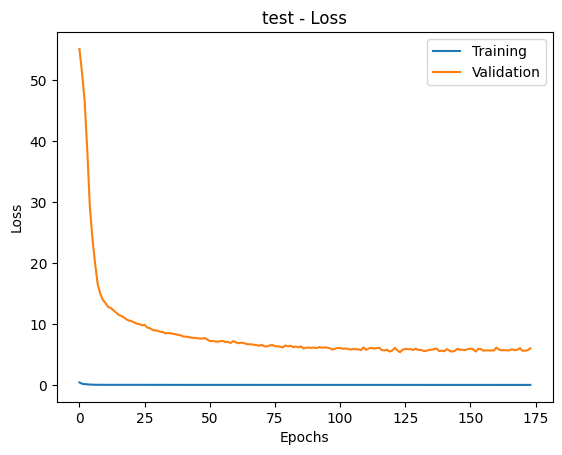

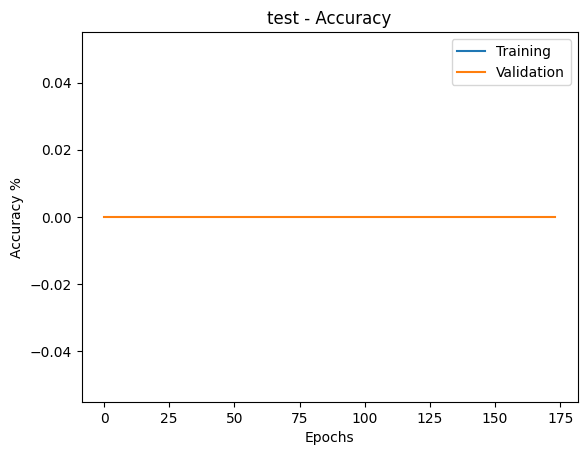

In [158]:
trainer.plot()

/home/caleb/personal/uni/dlp/a3-rnn-stock-prediction/utils/training3.py:205: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/caleb/personal/uni/dlp/a3-rnn-stock-predicti

torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([70, 30, 5])
torch.Size([70, 1, 5])
torch.Size([70, 1, 5])
(582, 30, 5)
(582, 3, 5)


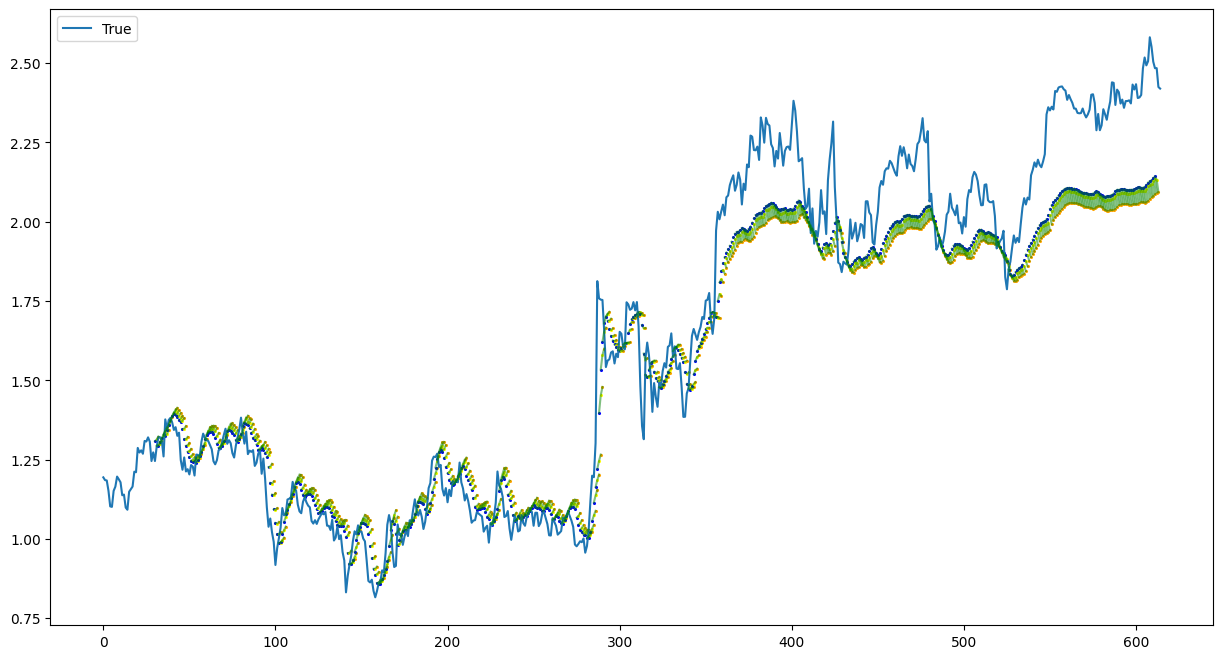

In [159]:
import numpy as np

all_inputs, _, all_predictions = trainer.infer(DataLoader(val_dataset, batch_size=128))

print(all_inputs.shape)
# print(all_outputs.shape)
print(all_predictions.shape)


def create_gradient_colors(array_length):
    """
    Create a gradient array transitioning from green to yellow, orange, and red.

    Parameters:
        array_length (int): Length of the array for the gradient.

    Returns:
        list: Array of RGB color tuples.
    """
    if array_length < 1:
        raise ValueError("Array length must be at least 1.")

    # Create a linear gradient from 0 to 1
    gradient = np.linspace(0, 1, array_length)

    # Generate the colors: Green (0,1,0) -> Yellow (1,1,0) -> Orange (1,0.5,0) -> Red (1,0,0)
    colors = [
        (1 - g, g, 0)  # Interpolates Red and Green channels
        for g in gradient
    ]

    colors.reverse()
    return colors


colours = ["blue", "yellow", "orange", "red"]
# colours = create_gradient_colors(4)
# print(colours)


# plot the input closes as a line, plot the predictions as points. each prediction is 4 steps ahead, make each step a different color
plt.figure(figsize=(15, 8))
plt.plot(val_df["Close_s"], label="True")

for i in range(0, all_predictions.shape[0]):
    for j, p in enumerate(all_predictions[i, :, 0]):
        plt.scatter([all_inputs.shape[1] + i + j], [p], c=colours[j], s=1.5)
    plt.plot(
        range(
            all_inputs.shape[1] + i, all_inputs.shape[1] + i + all_predictions.shape[1]
        ),
        all_predictions[i, :, 0],
        c="green",
        alpha=0.5,
    )

plt.legend()
plt.show()


# Now create a plotly plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=val_df["Date"], y=val_df["Close_s"], mode="lines", name="True")
)

for i in range(0, all_predictions.shape[0]):
    for j, p in enumerate(all_predictions[i, :, 0]):
        fig.add_trace(
            go.Scatter(
                x=[val_df["Date"][all_inputs.shape[1] + i + j]],
                y=[p],
                mode="markers",
                marker=dict(color=colours[j]),
                name="Prediction",
            )
        )
    fig.add_trace(
        go.Scatter(
            x=val_df["Date"][
                all_inputs.shape[1] + i : all_inputs.shape[1]
                + i
                + all_predictions.shape[1]
            ],
            y=all_predictions[i, :, 0],
            mode="lines",
            line=dict(color="green", width=1),
            name="Prediction",
        )
    )

fig.show()


In [162]:
from utils.strategy import run_strategy

all_inputs, _, all_predictions = trainer.infer(DataLoader(val_dataset, batch_size=128))

results = run_strategy(all_predictions[:, :, 0], val_df['3_day_price_diff'][30:-3])
print(results)

torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([128, 30, 5])
torch.Size([128, 1, 5])
torch.Size([128, 1, 5])
torch.Size([70, 30, 5])
torch.Size([70, 1, 5])
torch.Size([70, 1, 5])
0
shape: (582,)
Series: '3_day_price_diff' [f64]
[
	0.023954
	0.006008
	-0.019047
	0.017614
	0.011688
	…
	-0.000375
	-0.021842
	-0.015229
	-0.018184
	-0.014761
]
1
shape: (582,)
Series: '3_day_price_diff' [f64]
[
	0.023954
	0.006008
	-0.019047
	0.017614
	0.011688
	…
	-0.000375
	-0.021842
	-0.015229
	-0.018184
	-0.014761
]
2
shape: (582,)
Series: '3_day_price_diff' [f64]
[
	0.023954
	0.006008
	-0.019047
	0.017614
	0.011688
	…
	-0.000375
	-0.021842
	-0.015229
	-0.018184
	-0.014761
]
3
shape: (582,)
Series: '3_day_price_diff' [f64]
[
	0.023954
	0.006008
	-0.019047
	0.017614
	0.011688
	…
	-0.000375
	-0.021842
	-0.015229
	-0.018184
	-0

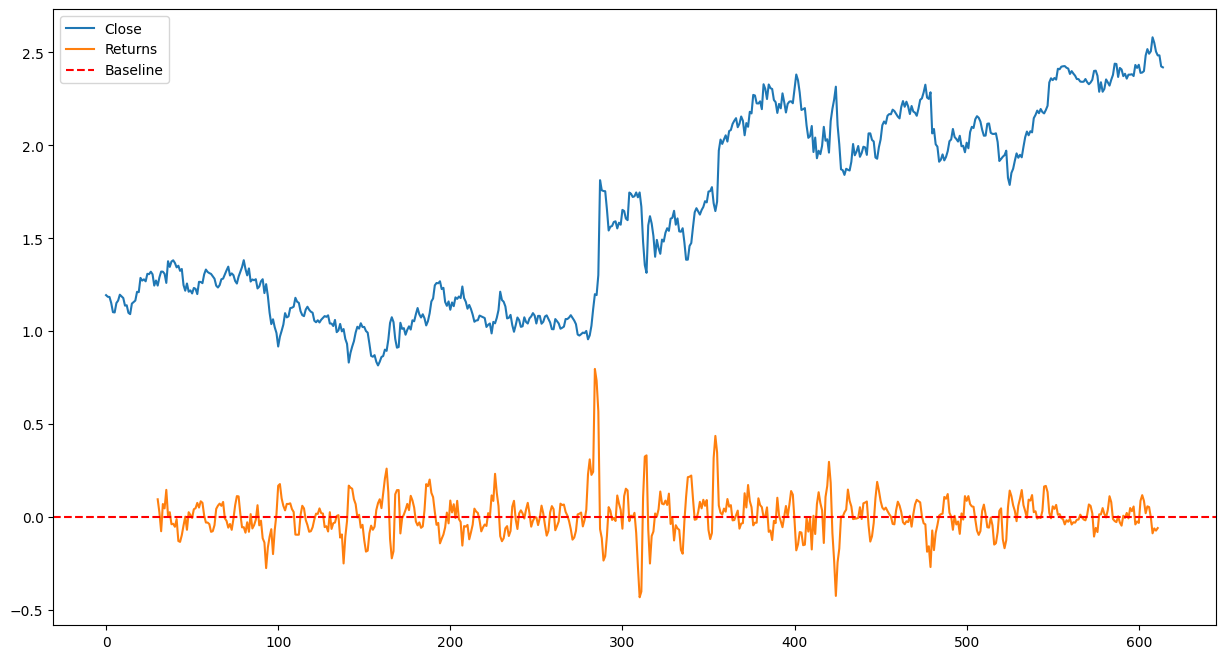

In [172]:
# plot returns with close price
plt.figure(figsize=(15, 8))
plt.plot(val_df["Close_s"], label="Close")
plt.plot(list(range(30, 30 + len(results['returns']))), np.array(results["returns"]) * 4, label="Returns")
plt.axhline(y=0, color='r', linestyle='--', label="Baseline")

plt.legend()
plt.show()